In [11]:
import pyemma as pm
from functions import discretize_trajectories, get_features, get_feature_traj_paths, bootstrap_ts2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import mdtraj as md
import warnings
import pickle

In [2]:
def f(df, ix):
    dim, lag, k = df.loc[ix, ['dim', 'lag', 'k']].values
    return {'vamp': {'dim': dim, 'lag': lag }, 'cluster_kmeans': {'k': k, 'max_iter': 1000}}


cols = sns.color_palette('colorblind')

def get_timescales(its):
    mean = np.mean(its, axis=0)
    lb = np.quantile(its, q=0.025, axis=0)
    ub = np.quantile(its, q=0.975, axis=0)
    return (mean, lb, ub)

def get_ratios(its):
    ratios = its[:, :, :-1]/its[:, :, 1:]
    mean = np.mean(ratios, axis=0)
    lb = np.quantile(ratios, q=0.025, axis=0)
    ub = np.quantile(ratios, q=0.975, axis=0)
    return (mean, lb, ub)


def plot_timescales(ax, its, lags):
    mean_its, lb_its, ub_its = get_timescales(its)
    for k in range(mean_its.shape[-1]):
        ax.plot(lags, mean_its[:, k], label=r'$t_{{{}}}$'.format(k+2))
        ax.fill_between(lags, lb_its[:, k], ub_its[:, k], alpha=0.2)

        
def plot_ratios(ax, its, lag_ix=-1):
    mean_its, lb_its, ub_its = get_ratios(its)
    for k in range(mean_its.shape[-1]):
        yerr = [[mean_its[lag_ix, k]-lb_its[lag_ix, k]], [ub_its[lag_ix, k]-mean_its[lag_ix, k]]]
        ax.errorbar(int(k+2), mean_its[lag_ix, k], yerr=yerr, label=r'$t_{{{}}}/t_{{{}}}$'.format(k+2, k+3), marker='o', color=cols[0])
        
        
def get_file_paths(sim_name, feature):
    glob_path = f'lag_determination/{sim_name}_{feature}_*.p'
    file_paths = glob(glob_path)
    return file_paths

def hp_label(hps):
    msg = rf"$\tau$: {hps['vamp']['lag']/10} ns, $m$: {hps['vamp']['dim']}, $n$: {hps['cluster_kmeans']['k']}"
    return msg

# Transition state

In [3]:
sim = 'transition_state'
lags = (np.arange(1, 50)*10).astype(int)
n_bootstrap = 100

ts = pd.read_csv(open('common/best_transition_state_hps.csv'))
ts.head()

,dim,lag,k,feature,y,mu
0,9,63,129,contact_filtered,2.801047,2.805985
1,10,144,67,contact_filtered,2.801575,2.804851
2,10,12,181,contact_filtered,2.805909,2.798779
3,10,104,161,phi_psi,2.773073,2.782259
4,10,238,188,phi_psi,2.791566,2.778040


## Contacts 

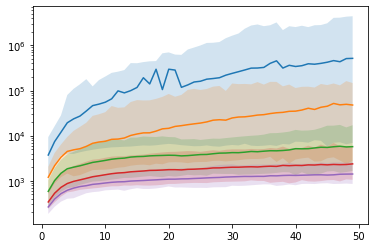

In [4]:
hps = f(ts, 0)
feature = 'contact_filtered'

traj_paths = get_feature_traj_paths(sim_name=sim, feature=feature)
bs_its = bootstrap_ts2(n=n_bootstrap, hps=hps, traj_paths=traj_paths, lags=lags)
fig, ax = plt.subplots()
plot_timescales(ax=ax, its=bs_its, lags=lags/10)
plt.yscale('log')

The contact feature doesn't give a very Markovian basis. 

## Phi/Psi

In [5]:
sim = 'transition_state'
feature = 'phi_psi'
hps = f(ts, 3)
traj_paths = get_feature_traj_paths(sim_name=sim, feature=feature)
bs_its = bootstrap_ts2(n=n_bootstrap, hps=hps, traj_paths=traj_paths, lags=lags)

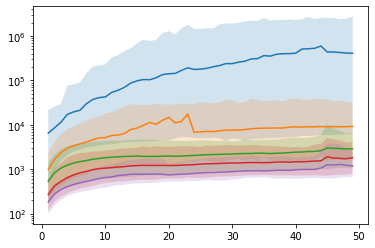

In [6]:
fig, ax = plt.subplots()
plot_timescales(ax=ax, its=bs_its, lags=lags/10)
plt.yscale('log')

## Bootstrap best model

In [7]:
def get_indices_in_state(dtrajs, state_set):
    return [[i for i in range(len(dtrajs[j])) if dtrajs[j][i] in state_set] for j in range(len(dtrajs))]


def get_ftraj_to_xtc_path(sim):
    arr = pd.read_table(f"{sim}/features/directory.txt", delimiter=':').values
    
    return {k : f"{sim}/aligned/{v.strip()}.xtc" for k, v in arr}

def get_dtrajs(trajs, hps):
    vamp = pm.coordinates.vamp(trajs, **hps['vamp'])
    y = vamp.get_output()
    kmeans = pm.coordinates.cluster_kmeans(y, **hps['cluster_kmeans'])
    dtrajs = [x.flatten() for x in kmeans.dtrajs]
    return dtrajs

def get_state_xtraj(dtrajs, xtrajs, states):
    state_ix = get_indices_in_state(dtrajs, states)
    state_xtraj = md.join([xtrajs[i][state_ix[i]] for i in range(len(state_ix))])
    return state_xtraj
    

In [9]:
sim = 'transition_state'
feature = 'phi_psi'
hps = f(ts, 3)
lag = 400
n_bootstrap = 100
n_sets = 2

# Trajectories
traj_paths = get_feature_traj_paths(sim, feature)
trajs = get_features(traj_paths)
n_trajs = len(trajs)

# xtc trajectories
ftraj_to_xtc_path = get_ftraj_to_xtc_path(sim)
top = md.load(f"{sim}/top.pdb")
xtrajs = [md.load(ftraj_to_xtc_path[k], top=top) for k in range(n_trajs)]

# bootstrap params
n_trajs = len(trajs)
probs = np.array([x.shape[0] for x in trajs])
probs = probs/np.sum(probs)
# output variables
out_dir = f'final_bootstraps/{sim}'
stride=10

In [12]:
np.random.seed(984357)
sim_data_lengths = np.zeros(n_bootstrap)

for i in range(n_bootstrap):
    rand_ix = np.random.choice(np.arange(n_trajs), p=probs, replace=True, size=n_trajs)
    samp_trajs = [trajs[i] for i in rand_ix]
    samp_xtrajs = [xtrajs[i] for i in rand_ix]
    
    sim_data_lengths[i] = np.sum([x.shape[0] for x in samp_trajs])
    
    dtrajs = get_dtrajs(samp_trajs, hps)
    mod = pm.msm.estimate_markov_model(dtrajs, lag=lag)
    pc = mod.pcca(n_sets)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ck = mod.cktest(nsets=n_sets)
    
    model = {'model': mod, 'ck_pred': ck.predictions, 'ck_est': ck.estimates}
    pickle.dump(file=open(f'{out_dir}/model_bs_{i}.p', 'wb'), obj=model)
    
    state_order = np.argsort(pc.coarse_grained_stationary_probability)
    for state_ix in state_order:
        states = mod.metastable_sets[state_ix]
        state_xtraj = get_state_xtraj(dtrajs, samp_xtrajs, states)
        state_xtraj[::stride].save(f'{out_dir}/state_{state_ix}_bs_{i}.xtc')
    


25-03-21 18:00:03 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[57] WARNING  Ignored error during estimation: Active set is empty. Cannot estimate MSM.
25-03-21 18:00:37 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[81] WARNING  Ignored error during estimation: Active set is empty. Cannot estimate MSM.
25-03-21 18:03:37 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[185] WARNING  Ignored error during estimation: Active set is empty. Cannot estimate MSM.
25-03-21 18:07:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[217] WARNING  Ignored error during estimation: Active set is empty. Cannot estimate MSM.
25-03-21 18:21:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[457] WARNING  Ignored error during estimation: Active set is empty. Cannot estimate MSM.
25-03-21 18:24:19 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[577] WARNING  Ignored error during estimation: Active